In [259]:
#import matplotlib
import matplotlib.pyplot as mp
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

import numpy as np
import metpy.calc as mpc
import xarray as xr
import scipy.ndimage as ndimage
import pandas as pd

In [260]:
import datetime as dt
#from scam_func import *

In [298]:
#### SCRIPT TO READ IN SCAM OUTPUT AND MAKE SOME PLOTS ####
###### IOP file info. ######

#xr.show_versions()
scam_file_num = '012a'  # For detailed single case analysis


## Multiple cases ##

#scam_file_nums = ['011a','011b','011c','011d']  # For comparisons
#scam_file_nums = ['012a','012b','012c','012d','012e','012f']  # For comparisons
#scam_file_nums = ['012a','012b','012f']
#scam_run_names = ['q_ft','0.5LS.T','no LS.Tq']

#scam_run_names = ['q_ft','0.5LS.T','0.5LS.q','0.5LS.Tq','0.25LS.Tq','no LS.Tq']

## Vertical resolution ##
#scam_file_nums = ['100a','100','100b','100c']
#scam_file_nums = ['101a','101','101b','101c','101d'] # 'a'=L16, ''=L32
#scam_run_names = ['L16','L32','L64','L128','L256']

#scam_file_nums = ['102a','102','102b','102c'] # 'a'=L15, ''=L30
#scam_run_names = ['L15','L30','L60','L120']


#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6','CAM5']


#scam_file_nums = ['101def','102def'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 default','CAM5 default']

#scam_file_nums = ['101','102'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 2 min','CAM5 2 min']

#scam_file_nums = ['101d','101dx'] # 'a'=L16, ''=L32
#scam_run_names = ['CAM6 until 4pm','CAM6 until 11:30pm']

#scam_file_nums = ['101d','201d','202d'] # 'a'=L16, ''=L32
#scam_run_names = ['gamma_coef=0.308','gamma_coef=0.285','gamma_coef=0.345']

scam_file_nums = np.array(['101d','203d','204d','LES']) # 'a'=L16, ''=L32
scam_run_names = ['clubb_c k10=0.5','clubb_c_k10=0.3','clubb_c_k10=1.0','LES']

scam_file_pre = "history/FSCAM.T42_T42.SAS."
scam_file_suf = ".cam.h0.2013-06-10-43200.nc"

les_file_in = "LES/patton_sas_stats.nc"
zoffset = 6.


#### PLOTTING ####

pvars_ts1d = np.array(['TS','PBLH','LHFLX','SHFLX','PRECC','PRECL','FLNS']) # D profile timeseries plots
#pvars_ts2d = ['DTV','VD01','DCQ','Q','T','TH','THL']

## WPSKEW is WP3_CLUBB/WP2_CLUBB**3/2
pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT', 
            'STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','WP3_CLUBB','THLP2_CLUBB','WP2_CLUBB'] # 2D profile timeseries plots
#pvars_ts2d = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']

#pvars_ts2d = ['STEND_CLUBB','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB'] 
    
pvars_snap = ['STEND_CLUBB','RVMTEND_CLUBB','TH','THL','Q','RVMTEND_CLUBB','WPTHLP_CLUBB','WPRTP_CLUBB','THLP2_CLUBB','WP2_CLUBB','WP3_CLUBB']  # Snapshot plotting vars
#pvars_snap = ['T','Q','RELHUM','TH','THL','CLOUD','ZMDQ','ZMDT','DTCOND','DCQ']
#pvars_snap = ['THL']
pvars_anim = np.array(('T','RELHUM','Q'))

tsnaps = np.array([6.,8.,10.,12.,14.,16])     # Time of snapshots (local time)


####### GRAPHICS ########
#mp.interactive(True)
#%matplotlib qt
%matplotlib inline


#### CONSTANTS #####

r_gas = 287.   # Specific gas constant for dry air
cp_air = 1004.6 # Specific heat for dry air
Lv = 2.501e6      # Latent heat of vaporization

r_cp = r_gas/cp_air    # r/cp
grav = 9.81     # Gravity ave.
p0 = 100000. # pref 

###### DERIVED VARS #######
scam_files_in = [scam_file_pre+x+scam_file_suf for x in scam_file_nums]

print('++++ Runs ++++')
print('')
scam_file_in = scam_file_pre+scam_file_num+scam_file_suf 
scam_fig_stub='png/'+'_'.join(scam_file_nums)

scam_files_in = np.where(scam_file_nums == "LES",les_file_in,scam_files_in) # Change to LES file if needed

rinfo = {}
rinfo['Run Name']  =  scam_run_names
rinfo['File Num']  =  scam_file_nums
rinfo['File Name'] =  scam_files_in

df_rinfo = pd.DataFrame(rinfo)
df_rinfo.style.set_properties(**{'background-color': 'black','color': 'yellow'})
#df_rinfo.style.apply({'background-color': 'white'})
print(df_rinfo)
print('')

##### Point Files #######

#scam_in = xr.open_mfdataset(scam_files_in,concat_dim='case', \
#                            data_vars=pvars_ts1d,compat='override')
#scam_in = xr.open_mfdataset(scam_files_in,concat_dim='case',combine='by_coords')
#xr.set_options(keep_attrs=True)
#print(scam_in)
## Dimensions ##

scam_in = xr.open_dataset(scam_files_in[0])

#vplevs = scam_in['lev'].transpose()
ntsnaps = tsnaps.size
ncases = len(scam_file_nums)

## Vertical range to plot

#pptop = 200.
#ipplevs = np.where(vplevs>=pptop) ; ip0 = np.min(ipplevs) ; ip1 = np.max(ipplevs)
#vplevs_v = vplevs[ip0:ip1]

++++ Runs ++++

          Run Name File Num                                          File Name
0  clubb_c k10=0.5     101d  history/FSCAM.T42_T42.SAS.101d.cam.h0.2013-06-...
1  clubb_c_k10=0.3     203d  history/FSCAM.T42_T42.SAS.203d.cam.h0.2013-06-...
2  clubb_c_k10=1.0     204d  history/FSCAM.T42_T42.SAS.204d.cam.h0.2013-06-...
3              LES      LES                            LES/patton_sas_stats.nc



        LHFLX  SHFLX     TS    PBLH       PRECL       PRECC   FLNS   CAPE
vscale    1.0    1.0    1.0     1.0  86400000.0  86400000.0    1.0    1.0
cmin      0.0    0.0  290.0     0.0         0.0         0.0  200.0    0.0
cmax    300.0  300.0  300.0  3000.0        10.0        10.0  800.0  800.0

****  TS  ****
<xarray.Dataset>
Dimensions:           (ilev: 257, lat: 1, lev: 256, lon: 1, nbnd: 2, time: 316)
Coordinates:
  * lat               (lat) float64 32.5
  * lon               (lon) float64 272.8
  * lev               (lev) float64 2.429 2.776 3.123 3.47 ... 995.3 997.2 999.1
  * ilev              (ilev) float64 2.255 2.602 2.949 ... 996.3 998.1 1e+03
  * time              (time) object 2013-06-10 12:00:00 ... 2013-06-10 22:30:00
Dimensions without coordinates: nbnd
Data variables:
    ntrk              float64 ...
    ntrn              float64 ...
    ntrm              float64 ...
    gw                (lat) float64 ...
    hyam              (lev) float64 ...
    hybm              

AttributeError: 'DataArray' object has no attribute 'time'

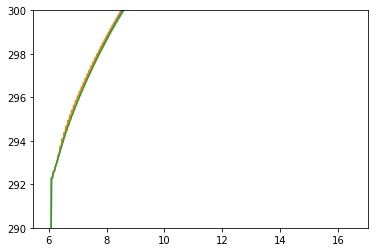

In [299]:
###### Plotting ##########

plot1d_ts_scam()   # 1D time series plots
#plot2d_ts_scam()   # 2D time series plots
#plot1d_snap_scam()   # 1D snapshot plots
#plot1d_anim_scam() # 2D animation  plots


In [248]:


#mp.show()

#fig.show()
#anim.save('sine_wave.gif', writer='imagemagick')


In [ ]:
#from IPython.core.interactiveshell import InteractiveShell
#InteractiveShell.ast_node_interactivity = "none"

In [297]:

################################
#   1D Timeseries plotting     #
################################

def plot1d_ts_scam():
    
    plot1d_dic = {}

    plot1d_dic['LHFLX']  = [1.,0.,300]
    plot1d_dic['SHFLX']  = [1.,0., 300]
    plot1d_dic['TS']     = [1., 290., 300.]
    plot1d_dic['PBLH']   = [1., 0., 3000.]
    plot1d_dic['PRECL']  = [86400.*1000., 0., 10.]
    plot1d_dic['PRECC']  = [86400.*1000., 0., 10.]
    plot1d_dic['FLNS']   = [1., 200., 800.]
    plot1d_dic['CAPE']   = [1., 0., 800.]

    plot1d_df = pd.DataFrame(plot1d_dic,index=['vscale','cmin','cmax'])
    print(plot1d_df)
    
    vleg_left = ['PBLH']
    

## 1D PLOTS ##
#mp.rcParams['figure.dpi'] = 50

    for var in pvars_ts1d:
    
        print('')
        print('**** ',var,' ****')

        vscale = plot1d_dic[var][0] ; cmin = plot1d_dic[var][1] ; cmax = plot1d_dic[var][2]
       
        vleg_x=0.085 if var in vleg_left else 0.97

       
        # Loop cases and plot
        for icase in range(0,ncases):
            scam_icase = xr.open_dataset(scam_files_in[icase],engine='netcdf4')
            print()
            time = scam_icase.time
            hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset
            hour_frac = hour_frac.values
            hour_frac = np.where(hour_frac<0,hour_frac+24.,hour_frac)
            
            with xr.set_options(keep_attrs=True): 
                pvar = vscale*scam_icase[var].isel(lat=0,lon=0)
            print('-- ',var,' ---- PLOTTING 1D TIME PLOTS ------>>>  ',pvar.attrs['long_name'])
            print(scam_file_nums[icase], ' --cmin/cmax --> ',  np.min(pvar.values),np.max(pvar.values))
            mp.plot(hour_frac,pvar)
            mp.ylim([cmin,cmax])
            
    # Axes stuff
        mp.xlabel("Local Time (hr)")
        mp.ylabel(pvar.attrs['units'])
        mp.title(pvar.attrs['long_name'])
        
        mp.legend(labels=scam_run_names, ncol=1, fontsize="medium",
                columnspacing=1.0, labelspacing=0.8, bbox_to_anchor= (vleg_x, 0.83),
                handletextpad=0.5, handlelength=1.5, borderaxespad=-5,
                framealpha=1.0,frameon=True)
#        mp.show()
        mp.savefig(scam_fig_stub+'_plot1d_ts_scam_'+var+'.png', dpi=300)     
        mp.close()
        
        
        
        
   

In [255]:
############################################
#  2D Time/Height Timeseries Plotting info. #
############################################ 


def plot2d_ts_scam():

    plot2d_dic = {}

    plot2d_dic['T']      = [1.,260.,305.,-.5,.5,scam_in['T'].attrs['units']]
    plot2d_dic['RELHUM'] = [1.,10., 120.,-10.,10.,'%']
    plot2d_dic['CLOUD']  = [100., 0., 100.,-10.,10.,'%']
    plot2d_dic['Q']      = [1000., 1., 12.,-1,1.,'g/kg']
 
    plot2d_dic['TH']  = [1., 290, 310.,-.5,.5,scam_in['T'].attrs['units']]
    plot2d_dic['THL']  = [1., 270, 310.,-2.,2.,scam_in['T'].attrs['units']]
    
    plot2d_dic['DCQ']  = [1000., -5., 5.,-1.,1.,'g/kg/day']
    plot2d_dic['DTCOND']  = [86400., -10., 10.,-1.,1.,'K/day']   
    
    plot2d_dic['ZMDT']  = [86400., -10., 10.,-1.,1.,'K/day']
    plot2d_dic['ZMDQ']  = [86400.*1000., -2, 2.,-8.,8.,'g/kg/day']
   
    plot2d_dic['CMFDT']  = [86400., -10., 10.,-10.,10.,'K/day']
    plot2d_dic['CMFDQ']  = [86400.*1000., -2, 2.,-8.,8.,'g/kg/day']
   
    

# BL/Turb. vars.                             
    plot2d_dic['DTV']  = [86400., -30., 13.,-1.,1.,'K/day']
    plot2d_dic['VD01']  = [86400.*1000., -50, 50.,-1.,1.,'g/kg/day']
    
    plot2d_dic['STEND_CLUBB']    = [86400./1000., -20, 20,-6.,6.,'K/day'] #J/kg.s -> K/day
    plot2d_dic['RVMTEND_CLUBB']  = [1000.*86400, -200., 200.,-20.,20.,'g/kg/day']
                                                       
    plot2d_dic['WPRTP_CLUBB'] = [1., -0., 600.,-100.,100.,scam_in['WPRTP_CLUBB'].attrs['units']]
    plot2d_dic['WPTHLP_CLUBB'] = [1., -100., 100.,-5.,5.,scam_in['WPTHLP_CLUBB'].attrs['units']]
    plot2d_dic['WPTHVP_CLUBB'] = [1., -100., 100.,-5.,5.,scam_in['WPTHVP_CLUBB'].attrs['units']]
    
    plot2d_dic['THLP2_CLUBB'] = [1., 0., 0.05,-0.01,0.01,scam_in['THLP2_CLUBB'].attrs['units']]   
    plot2d_dic['WP2_CLUBB']      = [1., 0., 1.,-0.1,0.1,scam_in['WP2_CLUBB'].attrs['units']] 

    plot2d_dic['WP3_CLUBB']      = [1., 0., 0.5,-0.05,0.05,scam_in['WP3_CLUBB'].attrs['units']]
    
 
### Vars that do not have -ve values in their full field.                             

    var_cmap0 = ['T','RELHUM','Q','CLOUD','THL','WPRTP_CLUBB','WP2_CLUBB','WP3_CLUBB','THLP2_CLUBB']
    plot2d_df = pd.DataFrame(plot2d_dic,index=['vscale','cmin','cmax','acmin','acmax','units'])
   
    print(plot2d_df.style.set_table_styles([{'selector':'','props':[('border','4px solid #7a7')]}]))
#   print(plot2d_df)

    nclevs = 20 # Number of contour levels
    ppmin = 500. ; ppmax = 1000. # Pressure (mb) plot range
    ptype = 'anom' # Full/anom/diff 
    cmap_full = 'Purples'
    cmap_anom = 'PRGn'
    
## TIME/HEIGHT PLOTTING ##



#######################
#### VARIABLE LOOP ####
#######################

    for var in pvars_ts2d:

        pvar = None
               
## VAR specific Scaling and contour intervals ##
        
        vscale = plot2d_dic[var][0] ; cmin = plot2d_dic[var][1] ; cmax = plot2d_dic[var][2]
        dcont = np.true_divide(cmax-cmin,nclevs,dtype=np.float)
        plevels = np.arange(cmin,cmax+dcont,dcont,dtype=np.float)
    
        acmin = plot2d_dic[var][3] ; acmax = plot2d_dic[var][4]
        adcont = np.true_divide(acmax-acmin,nclevs,dtype=np.float)
        aplevels = np.arange(acmin,acmax+adcont,adcont,dtype=np.float)
       
       # Take out zero contour
        aplevels[np.abs(aplevels) < 1e-10] = 0
        aplevels = aplevels[aplevels != 0]
                
        if ptype =='full': aplevels=plevels # Set to plevels if all full fields
    
        # Color maps for negative valued filled.
        pcmap=cmap_full if var in var_cmap0 else cmap_anom
        
    
### First case plot (could be only plot) ###
        scam_icase = xr.open_dataset(scam_files_in[0],engine='netcdf4') 

# Plev choice (fixing PS from first time)
        plevm = scam_icase['hyam']*p0 + scam_icase['hybm']*scam_icase['PS'].isel(lat=0,lon=0,time=0)
        plevi = scam_icase['hyai']*p0 + scam_icase['hybi']*scam_icase['PS'].isel(lat=0,lon=0,time=0)
    
### Derived Met variables ###
     
        if var in (['TH','THL']) : 
                pvar = scam_icase['T'].isel(lat=0,lon=0).transpose()*(p0/plevm)**r_cp 
                pvar.attrs['long_name'] = 'Potential Temperature' 
                pvar.attrs['units'] = 'K' 
                theta = pvar
        if var =='THL': 
                pvar = theta-(theta/scam_icase['T'].isel(lat=0,lon=0).transpose()) \
                    *(Lv/cp_air)*scam_icase['Q'].isel(lat=0,lon=0).transpose() 
                pvar.attrs['long_name'] = 'Liq. Water Potential Temperature'
                pvar.attrs['units'] = 'K' 
           
        if pvar is None :  # Set pvar if not already.
            pvar = scam_icase[var].isel(lat=0,lon=0).transpose()

            
            
### Determine Vertical Coord/Dim (lev/ilev) and time ###
        plev = plevi if 'ilev' in pvar.dims else plevm
        time = scam_icase.time
#        time_plot = time.time.dt.monotonic
        hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset
        hour_frac = hour_frac.values
        hour_frac = np.where(hour_frac<0,hour_frac+24.,hour_frac)
 
        
        print('---- PLOTTING 2D TIME/HEIGHT PLOTS------ >>>  ')
        print(' - ',var,' - ',pvar.attrs['long_name'],' -- cmin/cmax --> ',cmin,cmax)               
        print('Case = ',scam_file_nums[0],'Range=',np.min(pvar.values),np.max(pvar.values))
        

        
        
##############             
# First plot #
##############

        fig1 = mp.figure(figsize=(16, 5))
        ax1 = fig1.add_subplot(111)
        pvar0 = vscale*pvar
       
#        pvarp = pvarp-pvarp[:,0] # Remove initial column values
        
        plt0 = ax1.contourf(hour_frac,0.01*plev,pvar0,levels=plevels,cmap=pcmap,extend='both')   
        if ptype !='full': mp.colorbar(plt0, extend='both')
            
        plt0 = ax1.contour(hour_frac,0.01*plev,pvar0,levels=plevels,colors='black',linewidths=0.75)       
        
        ax1.clabel(plt0, fontsize=8, colors='black',fmt='%1.0f')

        mp.hlines(0.01*plev, min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.4)
        mp.suptitle(pvar.attrs['long_name']+(' - CLUBB' if 'CLUBB' in var else ' ')+' ('+plot2d_dic[var][5]+')')
        
        ax1.set_title(scam_run_names[0])
        ax1.set_ylabel('Pressure (mb)') 
        ax1.set_xlabel("Local Time (hr)")  
        ax1.set_ylim(ppmin, ppmax)
        ax1.invert_yaxis()  
        
            
#################################
# Loop for subsequent sub-plots #
#################################

        nn = len(fig1.axes)
    
        for icase in range(1,ncases):
           
            pvarp = None
        
            scam_icase = xr.open_dataset(scam_files_in[icase],engine='netcdf4')
            
            if var in (['TH','THL']) : 
                pvarp = scam_icase['T'].isel(lat=0,lon=0).transpose()*(p0/plevm)**r_cp 
                pvarp.attrs['long_name'] = "Potential Temperature" 
                pvarp.attrs['units'] = "K" 
                theta = pvarp
            if var =='THL': 
                pvarp = theta-(theta/scam_icase['T'].isel(lat=0,lon=0).transpose()) \
                    *(Lv/cp_air)*scam_icase['Q'].isel(lat=0,lon=0).transpose() 
                pvarp.attrs['long_name'] = "Liq. Water Potential Temperature"
          
            
            if pvarp is None :  # Set pvar if not already.
                pvarp = vscale*scam_icase[var].isel(lat=0,lon=0).transpose()
            
### Determine Vertial Coord (lev/ilev) + time
            plev = plevi if 'ilev' in pvar.dims else plevm
            time = scam_icase.time
            hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset
            hour_frac = hour_frac.values
            hour_frac = np.where(hour_frac<0,hour_frac+24.,hour_frac)
    
            print('Case = ',scam_file_nums[icase],'Range=',np.min(pvarp.values),np.max(pvarp.values))
            
            # Remove initial column values (anom) or case0 (diff)
            if ptype == 'anom' : pvarp = pvarp-pvar0 ; pcmap = cmap_anom
            if ptype == 'diff' : pvarp = pvarp-pvarp[:,0] ; pcmap = cmap_anom

### Reshape sub-fig placements            

            nn = len(fig1.axes)
           
            for i in range(nn):
                fig1.axes[i].change_geometry(1, nn+1, i+1)
            ax1 = fig1.add_subplot(1, nn+1, nn+1)
  
              
            pvarp_sm = pvarp
        #pvarp_sm = ndimage.gaussian_filter(pvarp, sigma=1, order=0)
 
            print(aplevels)
            plt0 = ax1.contourf(hour_frac,0.01*plev,pvarp_sm,levels=aplevels,cmap=pcmap,extend='both')

            # Squeeze in colorbar here so it doesn't get messed up by line contours
            mp.hlines(0.01*plev, min(hour_frac), max(hour_frac), linestyle="dotted",lw=0.4)

            if icase==ncases-1: 
                mp.subplots_adjust(right=0.9)  
                mp.colorbar(plt0, extend='both',cax=fig1.add_axes([0.92,  0.13, 0.02, 0.76]))
            plt0 = ax1.contour(hour_frac,0.01*plev,pvarp_sm,levels=aplevels, colors='black',linewidths=0.75)
            
                
            ax1.clabel(plt0, fontsize=8, colors='black',fmt='%1.2f')
                        
            ax1.set_title(scam_run_names[icase])
            ax1.set_xlabel("Local Time (hr)")
            ax1.set_ylim(ppmin, ppmax)
           
            ax1.yaxis.set_visible(False) # Remove y labels
            ax1.invert_yaxis()  
            
## Plot ##
        mp.savefig(scam_fig_stub+'_plot2d_ts_scam_'+var+'_'+ptype+'.png', dpi=300)              
        mp.show()
        
        del pvar       
        
        
        
     

In [251]:
   
        
        
        
###############################################
# 2D Snapshot/Height Timeseries Plotting info.
###############################################


def plot1d_snap_scam():
    plot_snap_dic = {}
    
    plot_snap_dic['T']      = [1.,260.,305.,-20.,20.,scam_in['T'].attrs['units']]
    plot_snap_dic['RELHUM'] = [1.,10., 120.,-100.,100.,'%']
    plot_snap_dic['CLOUD']  = [100., 0., 100.,-80.,80.,'%']
    plot_snap_dic['Q']      = [1000., 1., 12.,-5,5.,'g/kg']
 
    plot_snap_dic['TH']  = [1., 290, 310.,-20.,20.,scam_in['T'].attrs['units']]
    plot_snap_dic['THL']  = [1., 270, 310.,-20.,20.,scam_in['T'].attrs['units']]
    
    plot_snap_dic['DCQ']  = [1000., -5., 5.,-5.,5.,'g/kg/day']
    plot_snap_dic['DTCOND']  = [86400., -10., 10.,-10.,10.,'K/day']   
    
    plot_snap_dic['ZMDT']  = [86400., -10., 10.,-10.,10.,'K/day']
    plot_snap_dic['ZMDQ']  = [86400.*1000., -2, 2.,-8.,8.,'g/kg/day']
    
    plot_snap_dic['CMFDT']  = [86400., -10., 10.,-10.,10.,'K/day']
    plot_snap_dic['CMFDQ']  = [86400.*1000., -2, 2.,-8.,8.,'g/kg/day']
   
    
                              
# BL/Turb. vars.                             
    plot_snap_dic['DTV']  = [86400., -30., 13.,-10.,10.,'K/day']
    plot_snap_dic['VD01']  = [86400.*1000., -50, 50.,-8.,8.,'g/kg/day']
    
    plot_snap_dic['STEND_CLUBB']    = [86400./1000., -20, 20,-2.,2.,'K/day'] #J/kg.s -> K/day
    plot_snap_dic['RVMTEND_CLUBB']  = [1000.*86400, -50., 50.,-20.,20.,'g/kg/day']
                                                       
    plot_snap_dic['WPRTP_CLUBB'] = [1., -0., 600.,-50.,50.,scam_in['WPRTP_CLUBB'].attrs['units']]
    plot_snap_dic['WPTHLP_CLUBB'] = [1., -100., 100.,-50.,50.,scam_in['WPTHLP_CLUBB'].attrs['units']]
    plot_snap_dic['WPTHVP_CLUBB'] = [1., -100., 100.,-50.,50.,scam_in['WPTHVP_CLUBB'].attrs['units']]
    
    plot_snap_dic['THLP2_CLUBB'] = [1., 0., 0.05,-50.,50.,scam_in['THLP2_CLUBB'].attrs['units']]   
    plot_snap_dic['WP2_CLUBB']      = [1., 0., 1.,-0.5,0.5,scam_in['WP2_CLUBB'].attrs['units']] 

    plot_snap_dic['WP3_CLUBB']      = [1., 0., 0.5,-0.2,0.2,scam_in['WP3_CLUBB'].attrs['units']]
   
# Global stuff
   
    vleg_ul = ['TH','THL'] # Vars with leg in upper left
    
    ppmin = 500. ; ppmax = 1000. # Pressure (mb) plot range    
    
    var_anim = 'THL'
    run_anim = '101c'
    
    
    pvar_anim = None
    
##########################
## VARIABLE LOOP #########
##########################
         
    for var in pvars_snap:

        units = plot_snap_dic[var][5]
        
### PLOT STUFF FOR SUBLOT SETUP ###

        fig1 = mp.figure(figsize=(16, 5))
        ax1 = fig1.add_subplot(111)

        print('------ SNAPSHOTS ------>>>  ',var)

        # Plot several different functions...

        labelspacing = []
        labels = []
        
        
        
        
        
        
        
############################
## LOOP CASES AND SUBLOTS ##
############################

        nn = len(fig1.axes)

        for icase in range(0,ncases):

            
            pvar = None
            
            scam_icase = xr.open_dataset(scam_files_in[icase],engine='netcdf4') 
            # Vertical grid estimate.
            plevm = scam_icase['hyam']*p0 + scam_icase['hybm']*scam_icase['PS'].isel(lat=0,lon=0,time=0)
            
            time = scam_icase.time
            hour_frac = time.time.dt.hour+time.time.dt.minute/60.-zoffset
            
## Get Data ##
            if var in (['TH','THL']) : 
                pvar = scam_icase['T']*(0.01*p0/plevm)**r_cp 
                pvar.attrs['long_name'] = "Potential Temperature" 
                pvar.attrs['units'] = "K" 
                theta = pvar
            if var =='THL': 
                pvar = theta-(theta/scam_icase['T']) \
                    *(Lv/cp_air)*scam_icase['Q'] 
                pvar.attrs['long_name'] = "Liq. Water Potential Temperature"
          
            if pvar is None :  # Set pvar if not already.
                pvar = scam_icase[var]

                
                
## Trim down to vertical range and transpose ##

            plevs = plevm.sel(lev=slice(ppmin, ppmax)) # Prange
            pvar =  pvar.sel(lev=slice(ppmin, ppmax)) # Prange
            pvar =  pvar.isel(lat=0,lon=0) # remove lat/lon dims/transpose

#  
            print('------ CASE ------>>>  ', \
                    scam_run_names[icase],' -- ',scam_file_nums[icase],' -- ',var,' --- ', \
                    pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

    
    

                           
 
    
    
############################     
### LOOP SNAP SHOT TIMES ###
############################
        
            for ii in range(0, ntsnaps): 
            
                itt = np.min(np.where(hour_frac==tsnaps[ii])) # Plot at this time
                pvart = pvar[itt,:]
                
                
                cmap=mp.get_cmap("tab10")    
                mp.plot(pvart,0.01*plevs,color=cmap(ii)) 
            
                ax1.set_ylabel(units)
                ax1.set_xlabel(units)
                ax1.set_ylim(ppmin, ppmax)
#                ax1.set_xlim()
                ax1.invert_yaxis()  
                         
                if var not in ['T','TH','THL']: 
                    mp.vlines(0, 0, scam_icase[pvar.dims[1]].max(), linestyle="dashed",lw=1)
                mp.hlines(0.01*plevs, min(pvart), max(pvart), linestyle="dotted",lw=0.04) # plev horizontal lines
                
## PLOT PBLH IN PRESSURE ###
                
                pblh = scam_icase['PBLH'].isel(time=itt,lat=0,lon=0) 
                psurf = scam_icase['PS'].isel(time=itt,lat=0,lon=0) 
            
#                tt = the[ip-1]*(plevs[ip-1]/p0)**r_cp 
#                pblp = 0.01*(psurf-pblh*rho*grav)
                pblp = 0.01*psurf*np.exp(-pblh*grav/(r_gas*300.))
                
    
                mp.hlines(pblp, min(pvart), max(pvart), linestyle="dashed",lw=1,color=cmap(ii)) # plot approx PBL depth
### Legend ###
                mp.suptitle(pvar.attrs['long_name']+(' - CLUBB' if 'CLUBB' in var else ' ')+' ('+units+')')
 
                mp.title(scam_run_names[icase])
                lpos = 'upper left' if var in vleg_ul else 'upper right'
                mp.legend(labels=tsnaps, ncol=2, loc=lpos, 
                    columnspacing=1.0, labelspacing=1, 
                    handletextpad=0.5, handlelength=0.5, frameon=False)
               
### Reshape sub-fig placements (no need to do after last figure) ###

            
            if icase != ncases-1 :
    
                nn = len(fig1.axes)
           
                for i in range(nn):
                    fig1.axes[i].change_geometry(1, nn+1, i+1)
                ax1 = fig1.add_subplot(1, nn+1, nn+1)
     
# Save off variables/case for animation

        print(scam_file_nums[icase],' ',run_anim,' ',var,' ',var_anim)
        if var == var_anim and scam_file_nums[icase] == run_anim: pvar_anim = pvar 
        
#        mp.show()
        mp.savefig(scam_fig_stub+'_plot1d_snap_scam_'+var+'.png', dpi=300)    

        del pvar # Reset pvar array

# Animation
    if pvar_anim is not None:


        mp.cla()   # Clear axis
        mp.clf()   # Clear figure
        mp.close() # Close a figure window
#    fig1.close()


        print('+++ ANIMATION +++')
        print(pvar_anim)
        fig = mp.figure()
        ax = mp.axes(xlim=(0, 4), ylim=(-2, 2))
        line, = ax.plot([], [], lw=3)


### Add in animation for one of the cases ###
        def init():
            line.set_data([], [])
            return line,
        def animate(i):
            x = np.linspace(0, 4, 1000)
            y = np.sin(2 * np.pi * (x - 0.01 * i))
            line.set_data(x, y)
#            line.set_data(pvar_anim[i,:], pvar_anim['lev'])
            return line,  
        anim = FuncAnimation(fig, animate, init_func=init,
                           frames=100, interval=40, blit=True)
    
        #mp.close(anim._fig)

        HTML(anim.to_html5_video())           


  
        
        
        
        
        

In [252]:

#########################################
# 1D/TIME ANIMATIONS
#########################################

        
        
        
        
def plot1d_anim_scam():
    
    nanim_vars = pvars_anim.size
    
#    fig, ax = mp.subplots(nrows=1, ncols=nanim_vars,figsize=(15, 5)))
   
    
# 
#    def init():
#        line.set_data([], [])
#        return line,
#    def animate(i):
#        x = np.linspace(0, 4, 1000)
#        y = np.sin(2 * np.pi * (x - 0.01 * i))
#        line.set_data(x, y)
#        return line,

#    line, = ax.plot(x, np.sin(x))
          
    for var in pvars_anim:

        pvar = None

        if var in ('TH','THL') : pvar = scam_in['T'].isel(lat=0,lon=0)*(0.01*p0/vplevs)**r_cp ; pvar.attrs['long_name'] = "Potential Temperature" ; pvar.attrs['units'] = "K" ; theta = pvar
        if var =='THL': pvar = theta-(theta/scam_in['T'].isel(lat=0,lon=0))*(Lv/cp_air)*scam_in['Q'].isel(lat=0,lon=0) ; pvar.attrs['long_name'] = "Liq. Water Potential Temperature"

            
        if pvar is None :  # Set pvar if not already.
            pvar = scam_in[var].isel(lat=0,lon=0)

        print('------ Animations ------>>>  ',var,' --- ',pvar.attrs['long_name'],' -- min/max --> ',  np.min(pvar.values),np.max(pvar.values))

    # Dynamically allocate subplots and animate Animate

#    ax.plot(pvar[0,:],vplevs) ;  ax.invert_yaxis()
    
  
    fig = mp.figure()
    
    
# Plotting frame.    
    ax = fig.add_subplot(111)
    ax.set_ylabel('mb') 
    for ip in range(1,5):
        n = len(fig.axes)
        print(n)
        for i in range(n):
            fig.axes[i].change_geometry(1, n+1, i+1)
        ax = fig.add_subplot(1, n+1, n+1)   
        
    def animate(ii):
        print(n)
        for i in range(n):
            ax[n].plot[i](pvar[ii,:],vplevs) 
    
#        del fig.axes
#        mp.show()
#        return ax
        
        
#    def animate(ii):
#        print(len(fig.axes))
#        ax = fig.add_subplot(111)
#        
#        ax.set_ylabel('mb') 
#        ax.plot(pvar[ii,:],vplevs) ;  ax.invert_yaxis()
#        for ip in range(1,2):
#            n = len(fig.axes)
#            print("hi2",n)
#            for i in range(n):
#                fig.axes[i].change_geometry(1, n+1, i+1)
#            ax = fig.add_subplot(1, n+1, n+1)
#            ax.plot(pvar[ii,:],vplevs) ;  ax.invert_yaxis()
#        del fig.axes
#        mp.show()
#        return ax
    print(fig.axes)
    animate(0)
    mp.show()
    
#    print(fig)
#    animate(1)
#    print(fig)
#    animate(200)
        
#
#       def init():
#        line.set_data([], [])
#        return line,     
    
#       def animate(i):
#        x = np.linspace(0, 4, 1000)
#        y = np.sin(2 * np.pi * (x - 0.01 * i))
#        line.set_data(x, y)
#        return line, 
#        for ip in range(pvars_anim.size-1):
#            n = len(fig.axes)
#            for i in range(n):
#                fig.axes[i].change_geometry(1, n+1, i+1)
#            ax = fig.add_subplot(1, n+1, n+1)
#            ax.plot(pvar[0,:],vplevs) ;  ax.invert_yaxis()
        
        
    anim = FuncAnimation(fig, animate, frames=np.arange(1,10))
#    print(anim)
    #    mp.show()
    mp.show()
    HTML(anim.to_html5_video())

    del pvar
    
   

In [ ]:

print('+++ ANIMATION +++')
#        print(pvar_anim)
fig = mp.figure()
ax = mp.axes(xlim=(0, 4), ylim=(-20, 20))
line, = ax.plot([], [], lw=3)


### Add in animation for one of the cases ###
def init():
    line.set_data([], [])
    return line,
def animate(i):
    x = np.linspace(0, 4, 1000)
    y = 0.1*i*np.sin(np.pi * (x*0.1*i - 0.1 * i))**0.5
    line.set_data(x, y)
#            line.set_data(pvar_anim[i,:], pvar_anim['lev'])
    return line,  
anim = FuncAnimation(fig, animate, init_func=init,
                       frames=100, interval=40, blit=True)
mp.close(anim._fig)
HTML(anim.to_html5_video())       